In [21]:
import time

import numpy as np
import pandas as pd
from sklearn import datasets, linear_model, model_selection, base, \
    metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch Data

In [2]:
ds_name = "mnist_784"
start = time.time()
mnist = datasets.fetch_openml(ds_name, version=1)
end = time.time()
print(f"Data fetched in {round(end - start)} seconds")

Data fetched in 30 seconds


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
# Quick 'n' dirty display of one of the digits
sample_ix = 5
img_shape = (28, 28)
square_sample = mnist["data"][sample_ix].reshape(img_shape)
for i in range(28):
    s = ""
    for j in range(28):
        if square_sample[i, j] == 0:
            s += ". "
        else:
            s += "O "
    print(s)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . O O O O O . . . . . . . . 
. . . . . . . . . . . . . O O O O O O O . . . . . . . . 
. . . . . . . . . . . O O O O O O O O O O . . . . . . . 
. . . . . . . . . O O O O O O O O O O O O . . . . . . . 
. . . . . . . . . O O O O O O O . O O O O . . . . . . . 
. . . . . . . . . O O O O O O . . O O O O . . . . . . . 
. . . . . . . . . O O O O . . . . O O O O . . . . . . . 
. . . . . . . . . . . . . . . . . O O O O . . . . . . . 
. . . . . . . . . . . . . O O O O O O O O . . . . . . . 
. . . . . . . . . . O O O O O O O O O O . . . . . . . . 
. . . . . . . . O O O O O O O O O O O O O . . . . . . . 
. . . . . . . O O O O O O . O O O O O O O O . . . . . . 
. . . . . . O O O O O O . O O O

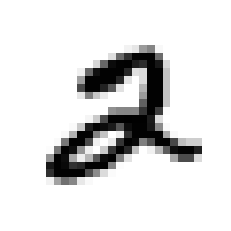

In [6]:
# With MPL instead...this is actually quicker lol
plt.imshow(square_sample, cmap="binary")
plt.axis("off");

In [7]:
X, y = mnist["data"], mnist["target"]

In [8]:
# Targets are given as strings
y[sample_ix]

'2'

## Preprocessing

In [9]:
y = y.astype(np.uint8)

In [10]:
# Construct a test set.
# Dataset is already shuffled
ix = 60000
X_train = X[:ix]
y_train = y[:ix]
X_test = X[ix:]
y_test = y[ix:]

## Binary Classifier

Simplify the problem to start -- is it possible to train a classifier to recognize the digit "5" against all other digits?

In [11]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [12]:
sgd_clf = linear_model.SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([X_train[0]])  # Known to be 5

array([ True])

In [27]:
# Evaluate the performance of the binary classifier
# 3-fold validation
scores = model_selection.cross_val_score(sgd_clf, X_train, y_train_5, cv=3)
scores

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# A naive baseline to compare against
# Always predicts "not-5"

# Should have an acuracy of about 90%

class Never5Classifier(base.BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
nv5_clf = Never5Classifier()
scores = model_selection.cross_val_score(nv5_clf, X_train, y_train, cv=3,
                                        scoring="accuracy")
scores

array([0.0997 , 0.0965 , 0.09995])

In [25]:
start = time.time()
y_train_pred = model_selection.cross_val_predict(sgd_clf, X_train, y_train_5,
                                                cv=3)
end = time.time()
print(f"Cross validated in {round(end - start)} seconds")

Cross validated in 27 seconds


In [26]:
# Rows are actual classes
# Columsn are predicted classes
metrics.confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [30]:
# When it predicts a 5, how often is it correct?
metrics.precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [31]:
# How many of the 5's does it pick up?
metrics.recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [32]:
# F1-Score is the harmonic mean of the two
metrics.f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [40]:
# use decision_function to use custom decision boundary
y_score = sgd_clf.decision_function([X_train[0]])
y_score

array([2164.22030239])

In [46]:
thresh = 0
pred = y_score > thresh
pred

array([ True])

In [47]:
# Higher threshold results in a negative prediciton
thresh = 8000
pred = y_score > thresh
pred

array([False])

In [49]:
# Using cross_val_score
y_scores = model_selection.cross_val_predict(sgd_clf, X_train, y_train_5,
                                             method="decision_function",
                                             cv=3)

In [52]:
# Using the predicted values to crea P/R curve
prcn, rcll, threshs = metrics.precision_recall_curve(y_train_5, y_scores)

In [64]:
def plot_pr_curves(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

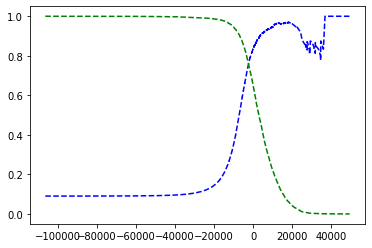

In [65]:
plot_pr_curves(prcn, rcll, threshs)

In [70]:
def plot_prec_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b")

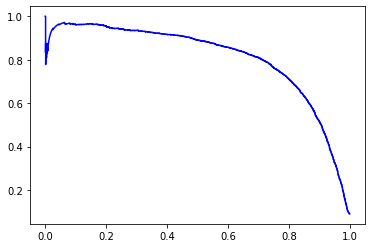

In [71]:
plot_prec_vs_recall(prcn, rcll)

In [72]:
# Left of @ PDF page 145